In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
import shap

In [94]:
random_state=42

In [95]:
try:
    train = pd.read_excel('/ML test task/ML_train.xlsx')
except:
    train = pd.read_excel('/Users/maiiayakusheva/Downloads/ML test task/ML_train.xlsx')

In [96]:
def initial_analysis(df):
    print('Пример строки датасета:')
    display(df.sample(1))
    print('Общая информация о датасете:')
    print(df.info())
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество пропусков:')
    print(df.isna().sum()[df.isna().sum()!=0])

In [97]:
initial_analysis(train)

Пример строки датасета:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
37698,1670798,Network-2,Saudi,Female,Child,2018-12-13,J03;J02;J21;J06.9,1,365,5,17,365,3


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    50000 no

In [98]:
def transform(data):
    data.dropna(subset='DoB', inplace=True)
    data.Insured_Network = [x[-1] for x in data.Insured_Network]
    data.Insured_Network = data.Insured_Network.astype(int) 
    data.Gender = np.where(data.Gender=='Male', 1, 0)
    data['age'] = pd.Series(np.round((datetime.datetime.now()-data.DoB).dt.total_seconds()/3600/24/365, 0)).astype(int)
    data.fillna(0, inplace=True)
    data['cnt_diag'] = [len(y) if y!=[0] else 0 for y in [str(x).split(';') for x in data.Diagnoses]]
    data.drop(['DoB', 'Diagnoses'], axis=1, inplace=True)
    return data


In [99]:
train = transform(train)
train = train.rename(columns=({'number_of_visits_23': 'target'}))	

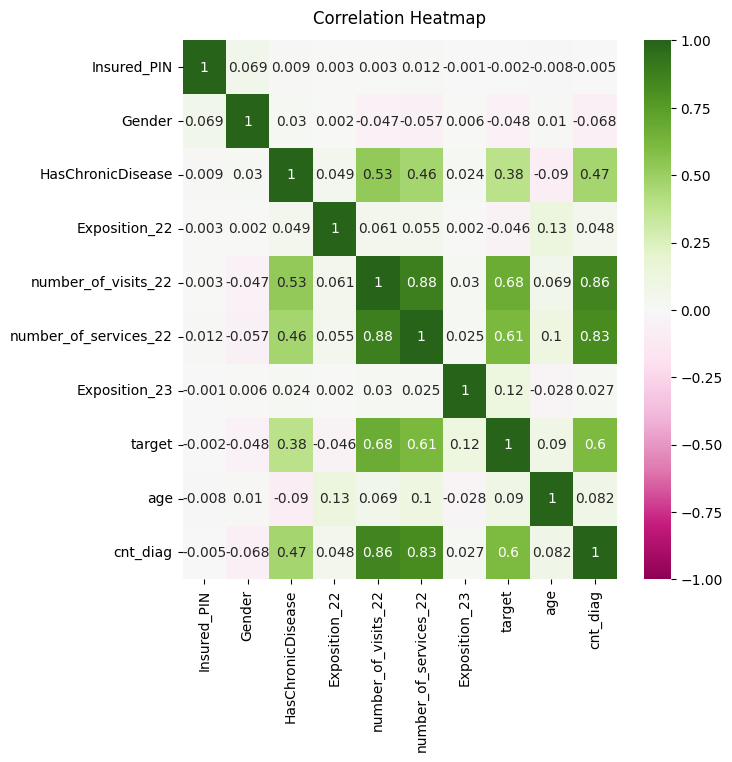

In [100]:
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(train.drop(['Insured_Network', 'Nationality', 'Relation'], axis=1).corr().round(3), vmin=-1, vmax=1, cmap='PiYG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [101]:
X = train.drop(['Insured_PIN', 'target', 'Gender'], axis=1)
y = train.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=random_state)

In [102]:
enc = OneHotEncoder()
scaler = StandardScaler().set_output(transform='pandas')
cat = []
num = []
for x in X_train.columns:
    if X_train[x].dtype == 'object':
        cat.append(x)
    if X_train[x].dtype == 'int64':
        num.append(x)

In [103]:
X_train = pd.concat([
    pd.DataFrame(enc.fit_transform(X_train[cat]).toarray(), columns=enc.get_feature_names_out(X_train[cat].columns), index=X_train.index),
    scaler.fit_transform(X_train[num])], axis=1)
X_val = pd.concat([
    pd.DataFrame(enc.transform(X_val[cat]).toarray(), columns=enc.get_feature_names_out(X_val[cat].columns), index=X_val.index),
    scaler.transform(X_val[num])], axis=1)

In [104]:
lr = LinearRegression().fit(X_train, y_train)
print('MSE:', round(mean_squared_error(y_val, lr.predict(X_val)), 2), 'MAE:', round(mean_absolute_error(y_val, lr.predict(X_val)), 2),\
     'R2:', round(r2_score(y_val, lr.predict(X_val)), 2))

MSE: 23.05 MAE: 3.23 R2: 0.48


In [105]:
lgbm = LGBMRegressor(force_col_wise=True).fit(X_train, y_train)
print('MSE:', round(mean_squared_error(y_val, lgbm.predict(X_val)), 2), 'MAE:', round(mean_absolute_error(y_val, lgbm.predict(X_val)), 2),\
     'R2:', round(r2_score(y_val, lgbm.predict(X_val)), 2))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 39999, number of used features: 18
[LightGBM] [Info] Start training from score 5.902723
MSE: 22.92 MAE: 3.16 R2: 0.49


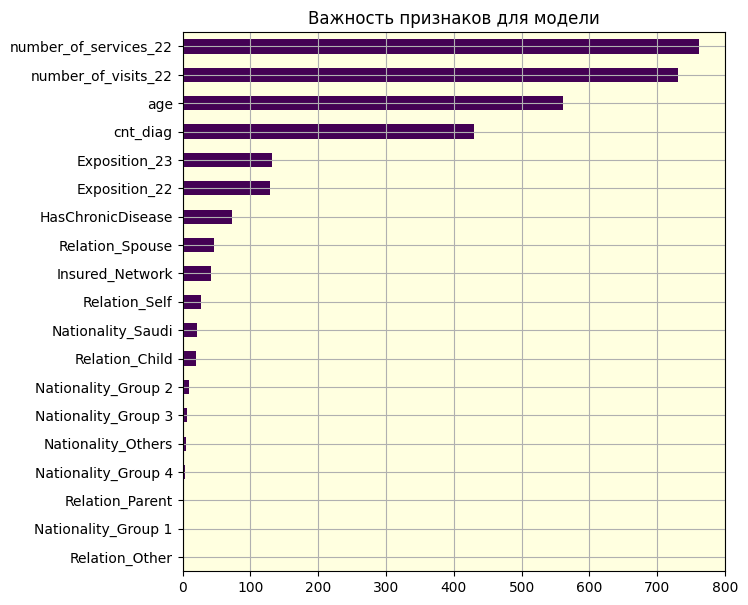

In [106]:
fig = pd.DataFrame(data={'score': lgbm.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score').plot(kind='barh', grid=True,
                        figsize=(7,7), legend=False, colormap='viridis', title='Важность признаков для модели')
fig.set(facecolor='lightyellow')
plt.show()

In [107]:
model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [108]:
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
39999/39999 - 12s - 295us/step - loss: 25.1288 - mse: 25.1288
Epoch 2/50
39999/39999 - 11s - 284us/step - loss: 24.2051 - mse: 24.2051
Epoch 3/50
39999/39999 - 11s - 280us/step - loss: 24.1954 - mse: 24.1954
Epoch 4/50
39999/39999 - 11s - 278us/step - loss: 24.1294 - mse: 24.1294
Epoch 5/50
39999/39999 - 11s - 278us/step - loss: 24.0654 - mse: 24.0654
Epoch 6/50
39999/39999 - 11s - 277us/step - loss: 24.0568 - mse: 24.0568
Epoch 7/50
39999/39999 - 11s - 274us/step - loss: 24.1071 - mse: 24.1071
Epoch 8/50
39999/39999 - 11s - 276us/step - loss: 23.9989 - mse: 23.9989
Epoch 9/50
39999/39999 - 11s - 283us/step - loss: 24.0085 - mse: 24.0085
Epoch 10/50
39999/39999 - 11s - 281us/step - loss: 24.0229 - mse: 24.0229
Epoch 11/50
39999/39999 - 11s - 281us/step - loss: 23.8386 - mse: 23.8386
Epoch 12/50
39999/39999 - 11s - 282us/step - loss: 23.8484 - mse: 23.8484
Epoch 13/50
39999/39999 - 11s - 281us/step - loss: 23.8318 - mse: 23.8318
Epoch 14/50
39999/39999 - 11s - 283us/step - lo

In [109]:
mse = model.evaluate(X_val, y_val, verbose=0)
mse

[22.28900718688965, 22.28900718688965]

In [110]:
preds = model.predict(X_val)
print('MSE:', round(mean_squared_error(y_val, preds), 2), 'MAE:', round(mean_absolute_error(y_val, preds), 2),\
     'R2:', round(r2_score(y_val, preds), 2))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
MSE: 22.29 MAE: 3.16 R2: 0.5


In [111]:
explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_train, check_additivity=False)

 99%|===================| 39644/39999 [01:08<00:00]       

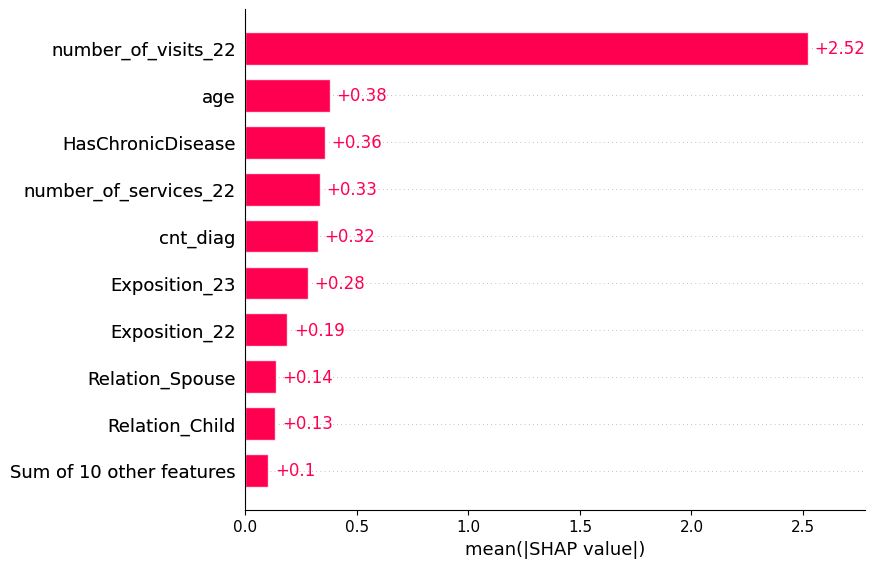

In [112]:
shap.plots.bar(shap_values)

In [113]:
try:
    test = pd.read_excel('/ML test task/ML_holdout.xlsx')
except:
    test = pd.read_excel('/Users/maiiayakusheva/Downloads/ML test task/ML_holdout.xlsx')

In [114]:
initial_analysis(test)

Пример строки датасета:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
1840,1398454,Network-2,Saudi,Male,Child,2013-07-30,K12.0;M62.60,0,365,2,4,365


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int64         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int64         
 8   Exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64(6), 

In [115]:
X_test = transform(test)
X_test = pd.concat([
    pd.DataFrame(enc.transform(X_test[cat]).toarray(), columns=enc.get_feature_names_out(X_test[cat].columns), index=X_test.index),
    scaler.transform(X_test[num])], axis=1)

In [116]:
test_preds = model.predict(X_test)
predictions = pd.concat([test[['Insured_PIN']], pd.DataFrame(test_preds, columns=['preds'])], axis=1)
#predictions.to_csv('/test_preds.csv')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


***Выводы:***
- после предварительного осмотра данных стало понятно, что в пропуски данных в значительном объеме есть только в столбце "Диагнозы", но из-за отсутствия дополнительной информации мною была принята гипотеза, что отсутствие данных - это осутствие поставленного диагноза, поэтому все пропуски быди заполнены нолями
- был выведен новый признак - количество поставленных диагнозов на уникального пациента
- в дальнейшем обработка самих наименований диагнозов, возможно через перевод их аббривиатур в векторное представление поможет модели более точно предсказывать количество посетителей клиники
- тепловая карта корреляции покала достаточно сильную линейную зависимость целевой переменной от признаков: количество посещений и количество оказанных услуг в 2022 году, наличие хронического заболевания и новым признаком - количество поставленных диагнозов на одного уникального пациента
- далее учебная выборка была разделена на тренировочную и валидационную части, категориальные данные закодированы, численные нормализованы
- построены модели-регрессоры: линейная регрессия от Sklearn, модель градиентого бустинга LGBMRegressor и простая нейронная сеть с линейными слоями на библиотеке Keras
- результаты работы всех моделей более менее сравнимы, лучшую целевую метрику дала НС, это MSE=22
- после визуализации показателей важности для модели градиентного бустинга, стало понятно что наибольший вес для нее имели признаки: количество услуг и посещений в 2022 году, возраст пациента, количество поставленных диагнозов, в принципе анализ шап значений показал схожие результаты.